In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from qdrant_client import QdrantClient
from qdrant_client.http import models
import uuid
import json

tab = pd.read_csv("pkm.csv")
tab

,id,description,nom,type
0,1,"Au matin de sa vie, la graine sur\r\nson dos l...",Bulbizarre,Pokémon Graine
1,1,Il a une étrange graine plantée sur son dos.\r...,Bulbizarre,Pokémon Graine
2,1,"Au matin de sa vie, la graine sur son dos lui ...",Bulbizarre,Pokémon Graine
3,1,Bulbizarre passe son temps à faire la sieste s...,Bulbizarre,Pokémon Graine
4,1,Il peut survivre plusieurs jours sans manger\r...,Bulbizarre,Pokémon Graine
...,...,...,...,...
1396,151,Nombre de scientifiques voient en\r\nlui l’anc...,Mew,Pokémon Nouveau
1397,151,Nombre de scientifiques voient en lui l’ancêtr...,Mew,Pokémon Nouveau
1398,151,Son ADN contient les codes génétiques de tous\...,Mew,Pokémon Nouveau
1399,151,On dit que Mew possède le code génétique de to...,Mew,Pokémon Nouveau


In [2]:
client = QdrantClient("qdrant", port=6333)

In [3]:
client.delete_collection(collection_name="pokemons")

True

In [4]:
client.create_collection(
    collection_name="pokemons",
    vectors_config=models.VectorParams(
        size=1024,
        distance=models.Distance.COSINE
    )
)

True

In [5]:
client.get_collections()

CollectionsResponse(collections=[CollectionDescription(name='pokemons')])

In [6]:
for i in range(len(tab)):
    response = requests.post(
        "http://ollama:11434/api" + "/embeddings",
        json = {
            "model": "snowflake-arctic-embed2:568m-l-fp16",
            "prompt": tab["description"][i],
        }
    )
    client.upsert(
        collection_name="pokemons",
        points=[
            models.PointStruct(
                id=str(uuid.uuid4()),
                vector=response.json()["embedding"],
                payload={
                    "numero": str(tab["id"][i]),
                    "nom": str(tab["nom"][i]),
                    "type": str(tab["type"][i]),
                    "description": str(tab["description"][i]),
                }
            )
        ]
    )

In [20]:
print(search_results.points[0])

id='fb03c223-a1d3-4ef4-addf-94a34c8234d2' version=557 score=0.6529242 payload={'numero': '63', 'nom': 'Abra', 'type': 'Pokémon Psy', 'description': 'Il dort 18 heures par jour. Il lui arrive de se\r\ntéléporter dans les arbres et d’en manger\r\nles Baies sans même se réveiller.'} vector=None shard_key=None order_value=None


In [26]:
query_prompt = "Il mange autant qu'il dort"
response = requests.post(
    "http://ollama:11434/api/embeddings",
    json={"model": "snowflake-arctic-embed2:568m-l-fp16", "prompt": query_prompt}
)
query_vector = response.json()["embedding"]

search_results = client.query_points(
    collection_name="pokemons",
    query=query_vector,
    limit=5
)

for i, result in enumerate(search_results.points, 1):
    print(f"\n[Result #{i}] ID: {result.id} | Score: {result.score:.3f}")
    print(json.dumps(result.payload, indent=2, ensure_ascii=False))
    print(f"{'-'*50}")


[Result #1] ID: 57d17d7f-abfb-431d-a0b3-d3e4bb2e5395 | Score: 0.648
{
  "numero": "143",
  "nom": "Ronflex",
  "type": "Pokémon Pionceur",
  "description": "Il mange 400 kg de nourriture par jour.\r\nIl arrive que sa sieste commence pendant qu’il\r\nmange, mais il continue à manger même endormi."
}
--------------------------------------------------

[Result #2] ID: 88516fe6-2eb8-4ae6-afcc-033cdee70613 | Score: 0.645
{
  "numero": "143",
  "nom": "Ronflex",
  "type": "Pokémon Pionceur",
  "description": "Il ne fait pas grand-chose à part manger\r\net dormir, mais gare à lui quand il décide\r\nde passer à l’action !"
}
--------------------------------------------------

[Result #3] ID: 7d8e8987-e9b2-4203-86b5-1ef66fef89c9 | Score: 0.635
{
  "numero": "46",
  "nom": "Paras",
  "type": "Pokémon Champignon",
  "description": "Il a beau manger autant qu’il peut,\r\nles champignons qui poussent sur son dos\r\nlui volent la plupart de ses nutriments."
}
---------------------------------------

In [33]:
all_points = client.scroll(
    collection_name="pokemons",
    limit=10000,
    with_payload=True,
    with_vectors=True
)[0]
embeddings = []
ids = []
for point in all_points:
    embeddings.append(point.vector)
    ids.append(point.payload.get("nom", point.id))
embeddings = np.array(embeddings)
cosine_matrix = cosine_similarity(embeddings)
print(cosine_matrix)

[[1.         0.50755159 0.3203516  ... 0.3782753  0.43168641 0.3804142 ]
 [0.50755159 1.         0.28364807 ... 0.32292464 0.39589042 0.31129591]
 [0.3203516  0.28364807 1.         ... 0.3979619  0.42370669 0.36775902]
 ...
 [0.3782753  0.32292464 0.3979619  ... 1.         0.34278194 0.29706629]
 [0.43168641 0.39589042 0.42370669 ... 0.34278194 1.         0.43082422]
 [0.3804142  0.31129591 0.36775902 ... 0.29706629 0.43082422 1.        ]]


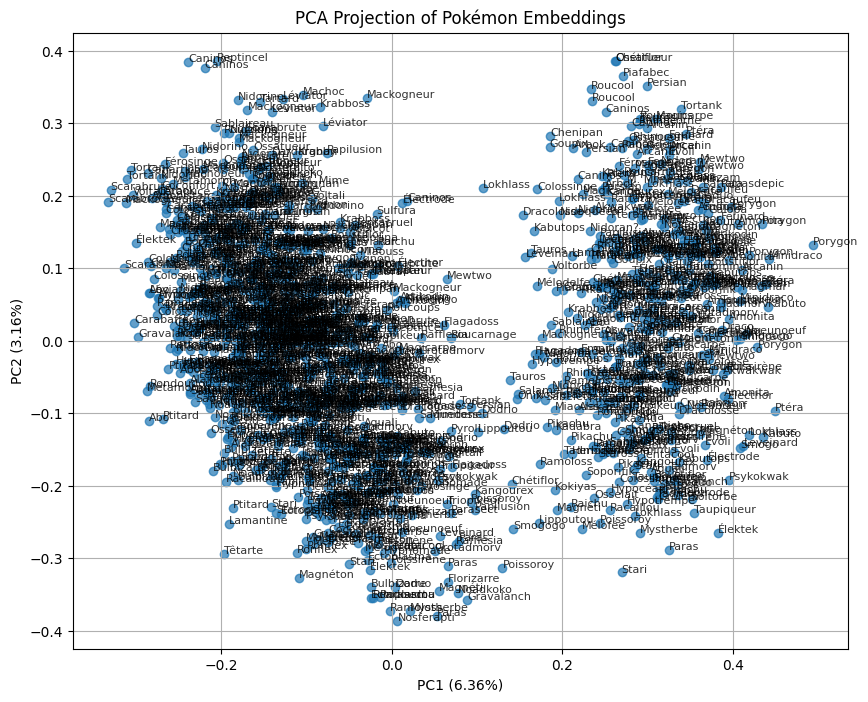

In [34]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)
explained_variance = pca.explained_variance_ratio_ * 100  # Convert to %
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
for i, name in enumerate(ids):
    plt.annotate(name, (pca_result[i, 0], pca_result[i, 1]), fontsize=8, alpha=0.8)
plt.xlabel(f"PC1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"PC2 ({explained_variance[1]:.2f}%)")
plt.title("PCA Projection of Pokémon Embeddings")
plt.grid(True)
plt.show()